# Demonstration of Dynamic Simulation (Impact of volt-var settings)

This example demonstrates how to use OpenDER to conduct a dynamic simulation. This example is converted from the python script example [here](../OpenDSS_VR_VV/regulator_volt-var_interaction.py).

The simplified test circuit includes a substation feeder head, distribution lines, a voltage regulator, a load that keeps constant consumption during simulation, and a PV DER with volt-var control.
This example demonstrates the impact of 3 different settings of volt-var control on the system operation. The simulated circuit and cases are shown below.

![Circuit Diagram](../OpenDSS_VR_VV/simulation_circuit_and_cases.png).

In [1]:
import numpy as np
import os
import pathlib
from opender_interface.der_interface import DERInterface
from opender import DER, DERCommonFileFormat
from opender_interface import TimePlots, CombinedTimePlots, XYPlots
import matplotlib.pyplot as plt

In [2]:
# circuit path
script_path = pathlib.Path(globals().get("__file__", "./_")).absolute()
circuit_folder = script_path.parents[1].joinpath("OpenDSS_VR_VV")
dss_file = circuit_folder.joinpath("circuit_vr.dss")
print(dss_file)  # make sure path to the OpenDSS circuit is correct.

C:\Users\pyma001\PycharmProjects\OpenDER_interface_github\Examples\OpenDSS_VR_VV\circuit_vr.dss


In [3]:
# configure the dynamic simulation
delt = 1  # sampling time step (s)

# configure distribution circuit line parameters
vbase = 12.47
sbase = 5
zbase = vbase ** 2 / sbase

xor1 = 3
xor2 = 1.5
zpu1 = 0.1
zpu2 = 0.2

rpu1 = zpu1 / np.sqrt(1 + xor1 ** 2)
xpu1 = rpu1 * xor1
rohms1 = rpu1 * zbase
xohms1 = xpu1 * zbase

rpu2 = zpu2 / np.sqrt(1 + xor2 ** 2)
xpu2 = rpu2 * xor2
rohms2 = rpu2 * zbase
xohms2 = xpu2 * zbase

In [4]:
# create 3 OpenDER interfaces for the 3 simulation cases
ckt_int_list = [DERInterface(dss_file, t_s=delt, print_der=False) for i in range(3)]

# create DER objects for the 3 simulation cases
derfiles = [DERCommonFileFormat(NP_P_MAX=5e6, NP_VA_MAX=5e6, NP_Q_MAX_INJ=5e6, NP_Q_MAX_ABS=5e6, QV_MODE_ENABLE=True)
            for i in range(3)]

derfiles[1].QV_CURVE_V1 = 0.96
derfiles[1].QV_CURVE_V2 = 1
derfiles[1].QV_CURVE_V3 = 1
derfiles[1].QV_CURVE_V4 = 1.04

derfiles[2].QV_CURVE_V1 = 0.96
derfiles[2].QV_CURVE_V2 = 1
derfiles[2].QV_CURVE_V3 = 1
derfiles[2].QV_CURVE_V4 = 1.04
derfiles[2].QV_VREF_AUTO_MODE = True

DER.t_s=delt

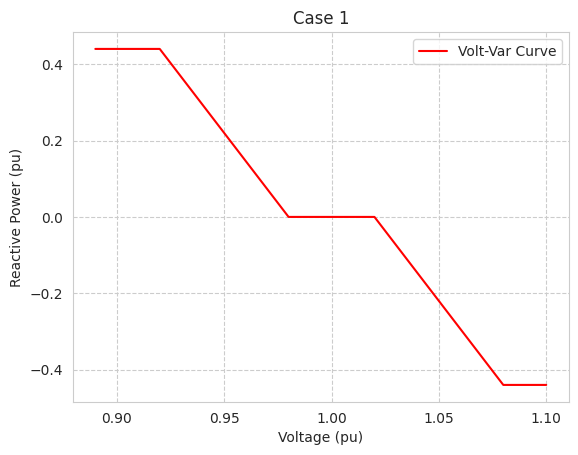

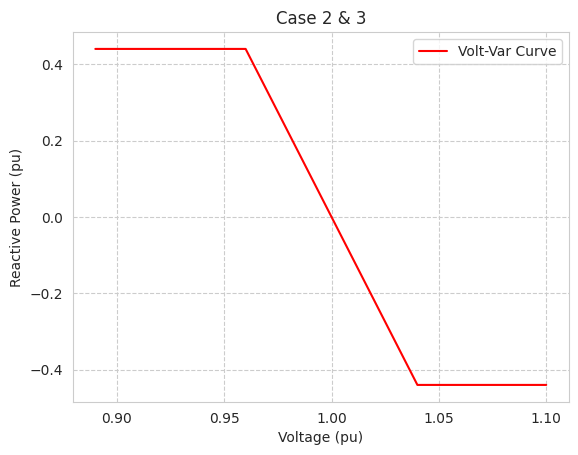

In [5]:
# plot volt-var settings
plot1 = XYPlots(DER(derfiles[0]))
plot1.prepare_vq_plot()
plot1.ax_vq.set_title('Case 1')
plot2 = XYPlots(DER(derfiles[1]))
plot2.prepare_vq_plot()
plot2.ax_vq.set_title('Case 2 & 3')
plt.show()

In [6]:
der_list = []
plot_list = []

# run the 3 cases sequentially
for i, ckt_int in enumerate(ckt_int_list):
    # create voltage regulator controls objects to replace the ones in the circuit
    ckt_int.create_vr_objs()

    # Update circuit line parameters
    ckt_int.cmd([f"line.line1.x1={xohms1}",
                 f"line.line1.r1={rohms1}",
                 f"line.line2.x1={xohms2}",
                 f"line.line2.r1={rohms2}",
                 f"line.line1.x0={xohms1}",
                 f"line.line1.r0={rohms1}",
                 f"line.line2.x0={xohms2}",
                 f"line.line2.r0={rohms2}",
                 ])

    ckt_int.initialize(DER_sim_type='PVsystem')

    # create OpenDER objects
    P_gen = 0
    der_list.append(ckt_int.create_opender_objs(derfiles[i], p_pu=0))

    # create voltage regulator controls objects to replace the ones in the circuit
    ckt_int.create_vr_objs()

    # set tap position to 0 for all three simulation cases, so they have the same initial condition.
    ckt_int.vr_objs[0].tap = 0
    ckt_int.write_vr()

    # disable voltage regulator controls in OpenDSS internal solver
    ckt_int.disable_control()

    # Solve power flow to get an initial simulation condition to start the dynamic simulation
    ckt_int.der_convergence_process()

    # create time-series plot object
    plot_obj = TimePlots(4, 1)
    plot_list.append(plot_obj)

    # run time series simulation for 400s
    for t in range(int(500/delt)):

        # Power ramp from 0 to 1 in 30s
        if t > 20:
            P_gen = min(1.0, P_gen+1/30*delt)

        ckt_int.update_der_p_pu([P_gen])

        # Obtain system voltage from previous power flow solution
        ckt_int.read_sys_voltage()
        # Simulate DER dynamics
        ckt_int.run()
        # Update DER outputs to circuit simulation
        ckt_int.update_der_output_powers()
        # set the new tap position into opendss
        ckt_int.write_vr()
        # Solve load flow
        ckt_int.solve_power_flow()

        # Save simulation results to time series plot for future plots
        plot_obj.add_to_traces(
            {
                # change 'der' to other locations ('xfmr_l', 'xfmr_h', 'sub_src') to see the voltage profile. 
                f'v (case {i+1})': sum(list(ckt_int.ckt.buses.loc['der', ['Vpu_A', 'Vpu_B', 'Vpu_C']]))/3, 
            },
            {
                f'P (case {i+1})': der_list[i][0].p_out_pu,
            },
            {
                f'Q (case {i+1})': der_list[i][0].q_out_pu,
            },
            {
                f'tap (case {i+1})': ckt_int.vr_objs[0].tap,
            }
        )


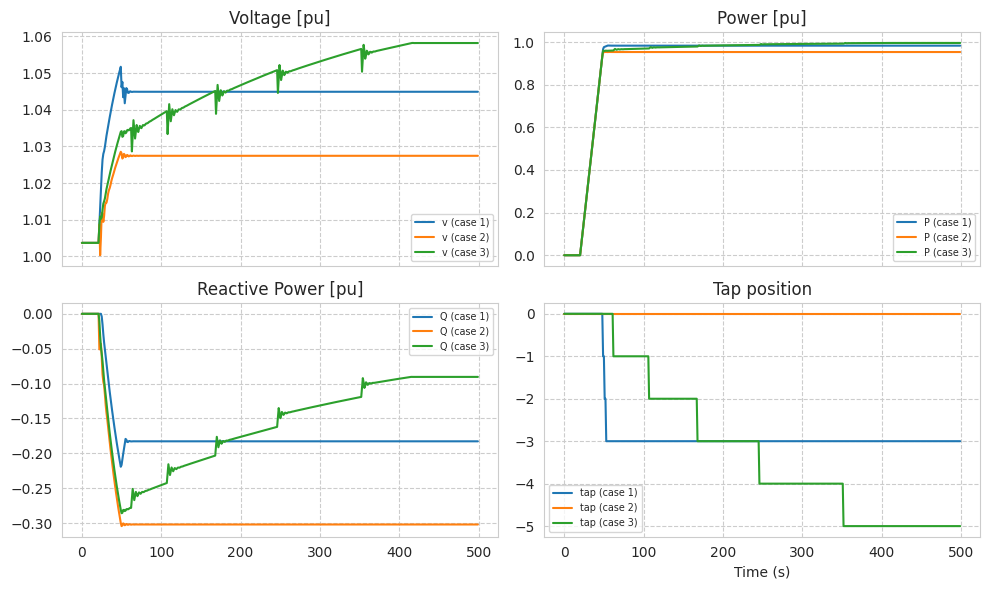

In [7]:
combined = CombinedTimePlots(2,2, ['Voltage [pu]', 'Power [pu]', 'Reactive Power [pu]', 'Tap position'])
combined.combine_time_plots(plot_list)
combined.prepare()
combined.fig.set_size_inches(10, 6)
for ax in combined.axes:
    ax.legend(fontsize='x-small')
    ax.grid()
combined.fig.tight_layout()
combined.show()

The simulated event is initiated by PV DER power increase from 0 to 1pu. Voltage rises due to increased DER output. To reduce voltage, DER starts to absorb reactive power and voltage regulator starts to tap.


The three cases include:
1. Default Category B volt-var setting2. 
Aggressive volt-var settin
3. 
Aggressive volt-var settinwith voltage reference tracking mode enabled (t autonomously adjusting reference volta)e
 
 As can be seen:
* Durint transient, case 2 and 3 with aggressive volt-var setting hthe lower voltapeaks at DER siteise compared to case 1 with default sett.ing
* In steady-state, Dabsorbsput the most reactive power in case 2, resulting in the lowest volt.
* For Case 3, reactive power output reduces gradually, since the voltage reference (Vref) gradually move to the measured voltage. Vref stops at 1.05pu, since the allowed range for Vref is defined as 0.95-1.05pu by IEEE 1547-2018. Thus the DER still absorbs some reactive power in steady-state.
* DER generates the most active power for case 3 due to reduced reactive power. However, the voltage regulator has the most tap operations for this case.



Note that this example is only to demonstrate the capability of OpenDER interface and possible impact of volt-var settings on distribution operation. It is not to provide guidance on what is the optimal volt-var setting.
* 